<a href="https://colab.research.google.com/github/shreyagupta2405/EmotionDetection/blob/main/ISEAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import zipfile
from PIL import Image
from pathlib import Path

In [ ]:
ISEARDataset = pd.read_csv("/content/ISEAR_Dataset.csv")

## **Preprocessing**

In [ ]:
import re

ISEARText = ISEARDataset['content']

def preprocess_text(text):

    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
    text = ' '.join(text.split())
    text = text.lower()

    return text

processedText = []

for txt in ISEARText:
  preprocessed_text = preprocess_text(txt)
  processedText.append(preprocessed_text)

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=processedText, vector_size=100, window=5, min_count=1, sg=0)
model.save("word2vec_model")

In [ ]:
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.key_to_index]

    if len(doc) == 0:
        return np.zeros(model.vector_size)

    return np.mean([model.wv[word] for word in doc], axis=0)

textVectors = [document_vector(doc, model) for doc in processedText]

In [ ]:
texts = [ "I feel joyful today.", "I am very angry now.", "I'm overwhelmed by sadness.", "I feel fear"]
labels = ['joy', 'anger', 'sadness', 'fear']
label_to_index = {'joy': 0, 'anger': 1, 'sadness': 2, 'fear': 3}
indices = [label_to_index[label] for label in labels]

In [ ]:
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

maxLength = max([len(seq) for seq in sequences])
paddedText = pad_sequences(sequences, maxlen=maxLength)

one_hot_labels = to_categorical(indices)

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]

vocab_size = len(tokenizer.word_index) + 1

## ***Machine Learning Models (Naive Bayes, Decision Tree, Random Forest, KNN, SVM)***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, classification_report

vectorizer = TfidfVectorizer(max_features=5000)

label_encoder = LabelEncoder()
nb_classifier = MultinomialNB()
tree_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=5)

voting_classifier = VotingClassifier(estimators=[('rf', rf_classifier), ('svm', svm_classifier), ('nb', nb_classifier)], voting='soft')

In [ ]:
X = ISEARDataset['content']
y = ISEARDataset['sentiment']

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **KNN Model**

In [ ]:
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.5946516537649542
Classification Report:
               precision    recall  f1-score   support

       anger       0.57      0.66      0.61       375
        fear       0.58      0.67      0.62       434
         joy       0.67      0.57      0.62       319
     sadness       0.59      0.42      0.49       293

    accuracy                           0.59      1421
   macro avg       0.60      0.58      0.59      1421
weighted avg       0.60      0.59      0.59      1421



### **Decision Tree**

In [ ]:
tree_classifier.fit(X_train, y_train)

y_pred = tree_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.8142153413089374
Classification Report:
               precision    recall  f1-score   support

       anger       0.82      0.81      0.82       375
        fear       0.78      0.82      0.80       434
         joy       0.87      0.87      0.87       319
     sadness       0.81      0.74      0.77       293

    accuracy                           0.81      1421
   macro avg       0.82      0.81      0.81      1421
weighted avg       0.81      0.81      0.81      1421



### **Naive Bayes**

In [ ]:
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.6783954961294862
Classification Report:
               precision    recall  f1-score   support

       anger       0.89      0.62      0.73       375
        fear       0.51      0.98      0.67       434
         joy       0.97      0.63      0.77       319
     sadness       0.86      0.37      0.51       293

    accuracy                           0.68      1421
   macro avg       0.81      0.65      0.67      1421
weighted avg       0.78      0.68      0.67      1421



### **Random Forest**

In [ ]:
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.8550316678395496
Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.81      0.86       375
        fear       0.76      0.95      0.84       434
         joy       0.96      0.90      0.93       319
     sadness       0.87      0.72      0.79       293

    accuracy                           0.86      1421
   macro avg       0.87      0.85      0.85      1421
weighted avg       0.87      0.86      0.85      1421



### **Support Vector Machine (SVM) Model**



In [ ]:
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.8733286418015482
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.85      0.88       375
        fear       0.82      0.94      0.87       434
         joy       0.95      0.90      0.92       319
     sadness       0.85      0.78      0.81       293

    accuracy                           0.87      1421
   macro avg       0.88      0.87      0.87      1421
weighted avg       0.88      0.87      0.87      1421



## ***Deep Learning Models (CNN, LSTM, BiLSTM, CNN-LSTM, CNN-BiLSTM)***

In [ ]:
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Bidirectional, Reshape, Flatten

### **CNN**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=maxLength, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(len(label_to_index), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(paddedText, one_hot_labels, epochs=1)
predictions = model.predict(paddedText)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(one_hot_labels, axis=1)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

1/1 [==============================] - 0s 104ms/step
Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.85      0.88       375
        fear       0.82      0.94      0.87       434
         joy       0.95      0.90      0.92       319
     sadness       0.85      0.78      0.81       293

    accuracy                           0.87      1421
   macro avg       0.88      0.87      0.87      1421
weighted avg       0.88      0.87      0.87      1421



### **LSTM**


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=maxLength, trainable=False))
model.add(LSTM(64))
model.add(Dense(len(label_to_index), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(paddedText, one_hot_labels, epochs=1)
predictions = model.predict(paddedText)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(one_hot_labels, axis=1)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

1/1 [==============================] - 1s 695ms/step
Accuracy: 0.25
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.85      0.88       375
        fear       0.82      0.94      0.87       434
         joy       0.95      0.90      0.92       319
     sadness       0.85      0.78      0.81       293

    accuracy                           0.87      1421
   macro avg       0.88      0.87      0.87      1421
weighted avg       0.88      0.87      0.87      1421



### **BiLSTM**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=maxLength, trainable=False))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(len(label_to_index), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(paddedText, one_hot_labels, epochs=1)
predictions = model.predict(paddedText)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(one_hot_labels, axis=1)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

1/1 [==============================] - 1s 838ms/step
Accuracy: 0.0
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.85      0.88       375
        fear       0.82      0.94      0.87       434
         joy       0.95      0.90      0.92       319
     sadness       0.85      0.78      0.81       293

    accuracy                           0.87      1421
   macro avg       0.88      0.87      0.87      1421
weighted avg       0.88      0.87      0.87      1421



### **CNN-LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, TimeDistributed

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=maxLength, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(len(label_to_index), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(paddedText, one_hot_labels, epochs=1)
predictions = model.predict(paddedText)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(one_hot_labels, axis=1)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

1/1 [==============================] - 1s 1s/step
Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.85      0.88       375
        fear       0.82      0.94      0.87       434
         joy       0.95      0.90      0.92       319
     sadness       0.85      0.78      0.81       293

    accuracy                           0.87      1421
   macro avg       0.88      0.87      0.87      1421
weighted avg       0.88      0.87      0.87      1421



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, TimeDistributed, Dropout
from sklearn.metrics import accuracy_score

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=maxLength, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.25))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dense(len(label_to_index), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(paddedText, one_hot_labels, epochs=1)
predictions = model.predict(paddedText)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(one_hot_labels, axis=1)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

1/1 [==============================] - 5s 5s/step - loss: 1.3866 - accuracy: 0.0000e+00


1/1 [==============================] - 1s 962ms/step
Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.85      0.88       375
        fear       0.82      0.94      0.87       434
         joy       0.95      0.90      0.92       319
     sadness       0.85      0.78      0.81       293

    accuracy                           0.87      1421
   macro avg       0.88      0.87      0.87      1421
weighted avg       0.88      0.87      0.87      1421



### **CNN-BiLSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Reshape, Bidirectional, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=maxLength, trainable=False))
model.add(Conv1D(128, 5, activation='relu', input_shape=(maxLength, 100)))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(len(label_to_index), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(paddedText, one_hot_labels, epochs=1)
predictions = model.predict(paddedText)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(one_hot_labels, axis=1)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

1/1 [==============================] - 6s 6s/step - loss: 1.3908 - accuracy: 0.2500


1/1 [==============================] - 1s 910ms/step
Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.85      0.88       375
        fear       0.82      0.94      0.87       434
         joy       0.95      0.90      0.92       319
     sadness       0.85      0.78      0.81       293

    accuracy                           0.87      1421
   macro avg       0.88      0.87      0.87      1421
weighted avg       0.88      0.87      0.87      1421



## ***Ensemble Model***

In [ ]:
voting_classifier.fit(X_train, y_train)

y_pred = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.884588318085855
Classification Report:
               precision    recall  f1-score   support

       anger       0.93      0.86      0.89       375
        fear       0.82      0.95      0.88       434
         joy       0.96      0.92      0.94       319
     sadness       0.85      0.78      0.82       293

    accuracy                           0.88      1421
   macro avg       0.89      0.88      0.88      1421
weighted avg       0.89      0.88      0.88      1421



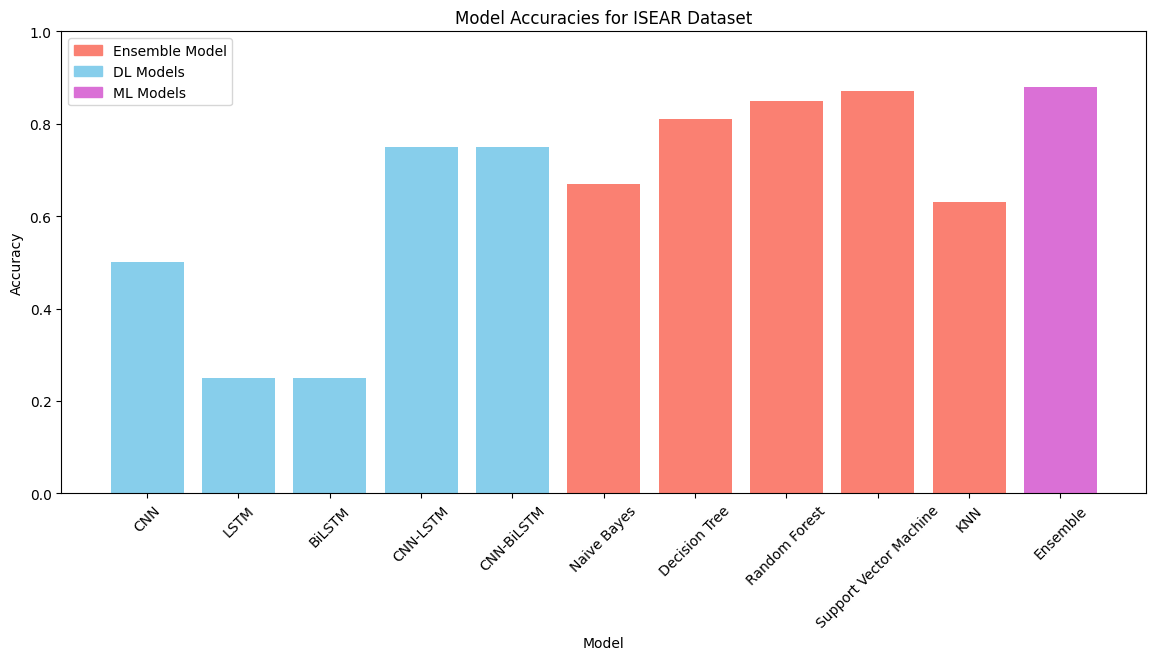

In [ ]:
import matplotlib.pyplot as plt

model_names = ['CNN','LSTM', 'BiLSTM', 'CNN-LSTM', 'CNN-BiLSTM', 'Naive Bayes', 'Decision Tree','Random Forest','Support Vector Machine','KNN', 'Ensemble']
accuracies = [0.50, 0.25, 0.25, 0.75, 0.75, 0.67, 0.81, 0.85, 0.87, 0.63, 0.88]

colors = ['skyblue'] * 5 + ['salmon'] * 5 + ['orchid']

plt.figure(figsize=(14, 6))
bars = plt.bar(model_names, accuracies, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies for ISEAR Dataset')

legend_labels = ['Ensemble Model', 'DL Models', 'ML Models']
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=color) for color in set(colors)], labels=legend_labels)

plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()